In [1]:
from typing import TypedDict, Optional, List, Dict, Any
import numpy as np
import pyrealsense2 as rs
import cv2
import base64
from PIL import Image
import io
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_community.document_loaders.image import UnstructuredImageLoader
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from dataclasses import dataclass

In [2]:
from color_frame_stream import RealSenseStream, ColorFrame

# Define the tools
def capture_and_encode_frame() -> str:
    """Captures and encodes a frame from RealSense Camera"""
    camera = RealSenseStream()
    try:
        color_frame = camera.streaming_color_frame()
        if color_frame.error:
            return f"Failed to capture frame: {color_frame.error}"
        
        pil_image = Image.fromarray(color_frame.image)
        buffer = io.BytesIO()
        pil_image.save(buffer, format="JPEG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    except Exception as e:
        return f"Error capturing frame: {str(e)}"
    finally:
        camera.stop()

In [3]:
class VisionAnalysisState(TypedDict):
    base64_image: str
    messages: str
    error: Optional[str]

In [11]:
# First, make sure you have your imports
from color_frame_stream import RealSenseStream, ColorFrame
import base64
from PIL import Image
import io

def capture_and_encode_frame(skip_frames=10) -> str:
    """
    Captures and encodes a frame from RealSense Camera
    
    Args:
        skip_frames (int): Number of frames to skip for camera stabilization
    """
    camera = RealSenseStream()
    try:
        # Skip initial frames for stabilization
        for _ in range(10):
            _ = camera.streaming_color_frame()
            
        # Capture the actual frame we want to use
        color_frame = camera.streaming_color_frame()
        
        if color_frame.error:
            return f"Failed to capture frame: {color_frame.error}"
            
        pil_image = Image.fromarray(color_frame.image)
        buffer = io.BytesIO()
        pil_image.save(buffer, format="JPEG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
        
    except Exception as e:
        return f"Error capturing frame: {str(e)}"
    finally:
        camera.stop()

# Now let's test it and display the image directly in the notebook
encoded_frame = capture_and_encode_frame(skip_frames=10)  # Skip first 10 frames

if encoded_frame.startswith("Failed") or encoded_frame.startswith("Error"):
    print(encoded_frame)
else:
    # Decode and display the image
    img_data = base64.b64decode(encoded_frame)
    img = Image.open(io.BytesIO(img_data))
    display(img)  # Jupyter will automatically display the image
    print(f"Image size: {img.size}")

RuntimeError: Failed to initialize RealSense pipeline: xioctl(VIDIOC_S_FMT) failed, errno=16 Last Error: Device or resource busy

In [5]:
# Call the function with a state parameter (you can pass an empty dict if not needed)
result = capture_and_encode_frame()

# Check the result
if "error" in result:
    print("Error occurred:", result["error"])
else:
    # Print first 100 characters of base64 string to verify format
    print("First 100 characters of base64 string:")
    print(result["base64_image"][:100])
    print("\nTotal length of base64 string:", len(result["base64_image"]))
    
    # Optionally display the image
    img_data = base64.b64decode(result["base64_image"])
    img = Image.open(io.BytesIO(img_data))
    display(img)
    print(f"\nImage size: {img.size}")

First 100 characters of base64 string:


TypeError: string indices must be integers

Starting capture...
Frame received - Size: (1280, 720), Mode: RGB


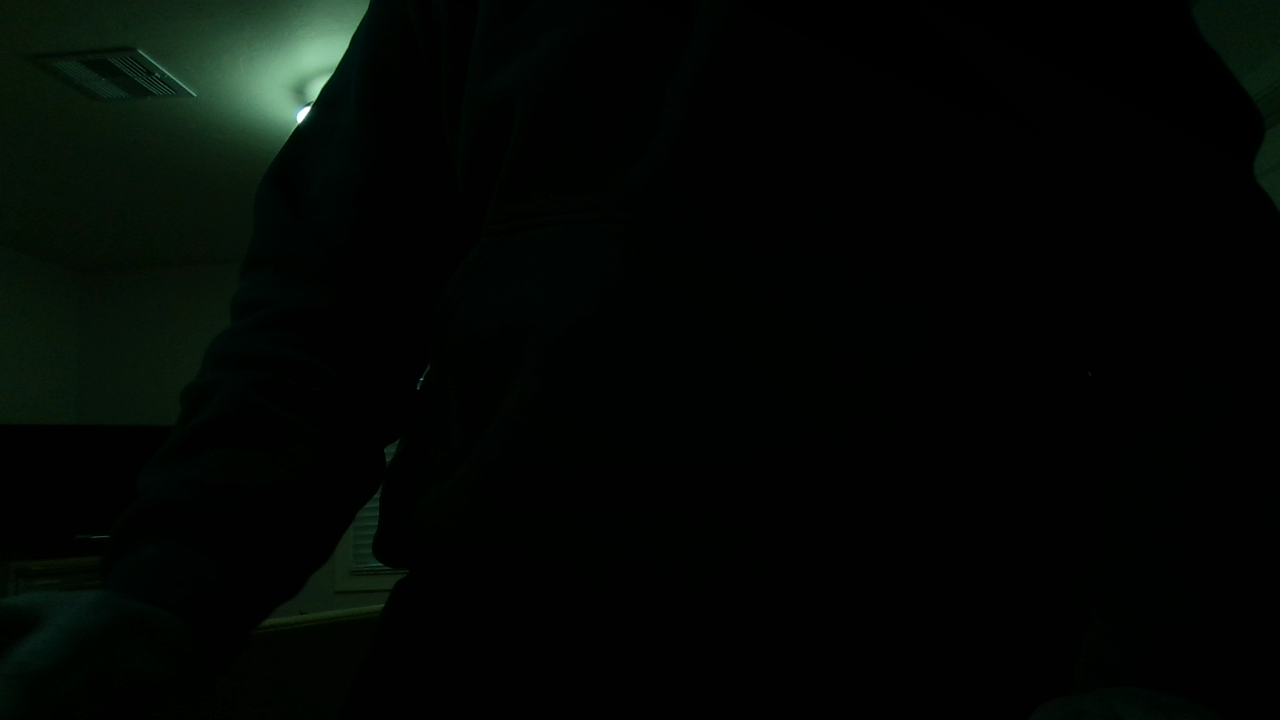

Error capturing frame: 'JPG'


In [21]:
# First, make sure you have your imports
from color_frame_stream import RealSenseStream, ColorFrame
import base64
from PIL import Image
import io
import cv2
import numpy as np

def capture_and_encode_frame() -> str:
    """Captures and encodes a frame from RealSense Camera"""
    camera = RealSenseStream()
    try:
        while True:  # Continuous loop to get frames
            color_frame = camera.streaming_color_frame()
            if color_frame.error:
                print(f"Failed to capture frame: {color_frame.error}")
                continue
                
            # Convert to PIL Image and display/print frame info
            pil_image = Image.fromarray(color_frame.image)
            print(f"Frame received - Size: {pil_image.size}, Mode: {pil_image.mode}")
            
            # Optional: display the frame if you're in a notebook
            display(pil_image)
            
            # Optional: if you want to encode and return a specific frame
            buffer = io.BytesIO()
            pil_image.save(buffer, format="JPG")
            encoded = base64.b64encode(buffer.getvalue()).decode("uint-8")
            print("Frame encoded successfully")
            
            # Break if you want to capture just one frame, or continue for stream
            # Remove this break if you want continuous streaming
            break
            
        return encoded
            
    except Exception as e:
        print(f"Error capturing frame: {str(e)}")
        return f"Error capturing frame: {str(e)}"
    finally:
        camera.stop()

# Test the function
print("Starting capture...")
encoded_frame = capture_and_encode_frame()

if encoded_frame and not (encoded_frame.startswith("Failed") or encoded_frame.startswith("Error")):
    print("\nDecoding and displaying final captured frame:")
    img_data = base64.b64decode(encoded_frame)
    img = Image.open(io.BytesIO(img_data))
    display(img)
    print(f"Final image size: {img.size}")

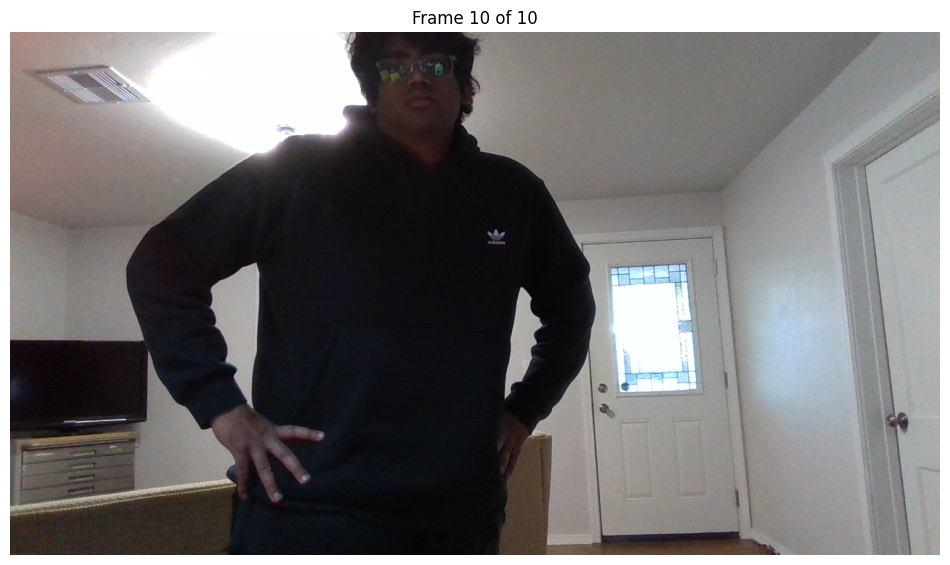

Frame 10/10
Shape: (720, 1280, 3)
Data type: uint8
Min/Max pixel values: 0/255


In [23]:
from IPython.display import clear_output, display
import time

import matplotlib.pyplot as plt

def display_frames(num_frames=10, delay=0.1):
    """
    Display frames from RealSense camera in Jupyter Lab
    
    Args:
        num_frames (int): Number of frames to display
        delay (float): Delay between frames in seconds
    """
    camera = RealSenseStream()
    
    try:
        plt.figure(figsize=(12, 8))
        for i in range(num_frames):
            color_frame = camera.streaming_color_frame()
            
            if color_frame.error:
                print(f"Frame {i+1} error: {color_frame.error}")
                continue
                
            # Clear previous output
            clear_output(wait=True)
            
            # Display the frame
            plt.imshow(color_frame.image)
            plt.axis('off')
            plt.title(f'Frame {i+1} of {num_frames}')
            display(plt.gcf())
            
            # Print frame information
            print(f"Frame {i+1}/{num_frames}")
            print(f"Shape: {color_frame.image.shape}")
            print(f"Data type: {color_frame.image.dtype}")
            print(f"Min/Max pixel values: {color_frame.image.min()}/{color_frame.image.max()}")
            
            time.sleep(delay)
            
            
    except Exception as e:
        print(f"Error during streaming: {str(e)}")
    finally:
        camera.stop()
        plt.close()

# Run the function to display frames
display_frames()

In [ ]:
## License: Apache 2.0. See LICENSE file in root directory.
## Copyright(c) 2015-2017 Intel Corporation. All Rights Reserved.

###############################################
##      Open CV and Numpy integration        ##
###############################################

import pyrealsense2 as rs
import numpy as np
import cv2

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

try:
    while True:

        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape

        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((resized_color_image, depth_colormap))
        else:
            images = np.hstack((color_image, depth_colormap))

        # Show images
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', images)
        cv2.waitKey(1)

finally:

    # Stop streaming
    pipeline.stop()

KeyboardInterrupt: 

: 